In the [previous notebook](../apply_winsorization.ipynb), methods for removing outliers in the emissions spectra are studied. In this notebook, I examine the effects of applying these smoothing techniques on the fits themselves. I'll use Zac's `hyperFeatureSearch()` to determine which parameters provide the best fit.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pysyncon import Dataprep, Synth, AugSynth
import itertools

In [9]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
# Ignore AK and HI because they aren't in the continental US
# Ignore CA and WA because they have strong CO2 policies in the pre-treatment period
# Ignore VA because it was only a member of RGGI briefly
# Ignore WY, ND, and WV because they are per capita emissions outliers
other_states = ["CA", "WA", "VA", "AK", "HI", "WY", "ND", "WV"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

# Verify all fifty states accounted for:
assert(len(rggi_states) + len(control_states) + len(other_states) == 50)

In [10]:
# Read in the dataframe
df = pd.read_csv(os.path.join("..", "..", "..", "SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]

In [11]:
# Do some per capita calculations:
df['co2_per_capita']   = df['monthly_emissions']   / df['monthly_population']
df['gdp_per_capita']   = df['gdp_rel_2017_interp'] / df['monthly_population']
df['euse_per_capita']  = df['monthly_energy_use']  / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['eflow_per_capita'] = df['monthly_energy_flow'] / df['monthly_population']

In [ ]:
# Add some smoothing:
# Let's be a little agressive here for a more pronounced potential affect
# Remove the 5% extremes
from scipy.stats.mstats import winsorize
df["co2_per_capita_sma"] = df["monthly_emissions_sma"] / df["monthly_population"]
df["co2_per_capita_residuals"] = df["co2_per_capita"] - df["co2_per_capita_sma"]
winsorize(df["co2_per_capita_residuals"], limits=(0.05,0.05))
df["co2_per_capita_winsorized"] = df["co2_per_capita_residuals"] + df["co2_per_capita_sma"]

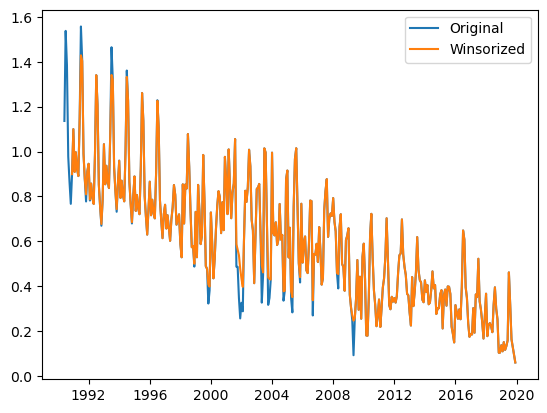

In [21]:
# Plot to make sure smoothing worked
plt.plot(df[df.state=="DE"].date, df[df.state=="DE"].co2_per_capita, label="Original")
plt.plot(df[df.state=="DE"].date, df[df.state=="DE"].co2_per_capita_winsorized, label="Winsorized")
plt.legend()
plt.show()

In [35]:
#monthly_features_of_interest_unscaled = ['monthly_emissions', 'prcp', 'snow', 'tavg', 
#        'gdp_rel_2017_interp', 'monthly_energy_prod',
#       'monthly_energy_use', 
#       'monthly_energy_flow', 
#        'monthly_renew_pct', 'monthly_fossil_pct',
#       'monthly_pop_density', 'monthly_emissions_sma']

monthly_features_of_interest = ['prcp', 'snow', 'tavg', 
        'gdp_per_capita', 
        'euse_per_capita', 'eprod_per_capita', 'eflow_per_capita', 
        'monthly_renew_pct', 'monthly_fossil_pct', 
        'monthly_pop_density']

def hyperFeatureSearch(numFeatures, filename, winsorize=False):
    scores_df = pd.DataFrame(columns=["Features", "AvgLossSyn"])
    scores_df = scores_df.astype('object')

    # Choose features to test
    for features in itertools.combinations(monthly_features_of_interest, numFeatures):
    
        # Loop over RGGI states
        loss_array = np.zeros(len(rggi_states))
        counter = 0
        for rggi_state in rggi_states:
            state_id = rggi_state 
            control_ids = list(set(control_states) - set([state_id]))
            rggi_ids = list(set(rggi_states) - set([state_id]))

            # Stop the notebook if something goes wrong
            assert(state_id not in other_states)
            assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

            # Do computations monthly
            month_jumps = 1

            # Set up ranges
            UL = 2009
            LL_TIME = 1997      # Time range over which to perform fit

            preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

            #years = pd.date_range(start='1997-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]
            
            #special_predictors = [(feature, preintervention_time_range, 'mean') for feature in features]
            
            dependent = "co2_per_capita"
            if winsorize:
                dependent = "co2_per_capita_winsorized"
            additional_predictors = [feature for feature in features]

            dataprep_control = Dataprep(
                foo=df,
                predictors=[dependent]+additional_predictors,
                predictors_op="mean",
                time_predictors_prior=preintervention_time_range,
                #special_predictors=special_predictors,
                dependent=dependent,
                unit_variable="state",
                time_variable="date",
                treatment_identifier=state_id,
                controls_identifier= control_ids,
                time_optimize_ssr=preintervention_time_range
            )
            
            # Do a synthetic control fit to the data using control states
            synth = Synth()

            synth.fit(dataprep=dataprep_control)
            loss_array[counter] = synth.loss_V
            counter += 1
            
        feature_avg_loss = np.average(loss_array)
        result = pd.DataFrame(data=[[list(features),feature_avg_loss]], columns=["Features", "AvgLossSyn"], dtype='object')
        scores_df = pd.concat([scores_df, result])
        
    output = filename + "_" + str(numFeatures) + ".csv"
    scores_df.to_csv(output)

In [ ]:
hyperFeatureSearch(1, "hyperSearch_scores")
print("One done")
hyperFeatureSearch(2, "hyperSearch_scores")
print("Two done")
hyperFeatureSearch(3, "hyperSearch_scores")
print("Three done")
hyperFeatureSearch(4, "hyperSearch_scores")
print("Four done")
#hyperFeatureSearch(5, "hyperSearch_scores")
#print("Five done")

One done
Two done
Three done
Four done


KeyboardInterrupt: 

In [36]:
hyperFeatureSearch(1, "hyperSearch_scores_win", True)
print("One done")
hyperFeatureSearch(2, "hyperSearch_scores_win", True)
print("Two done")
hyperFeatureSearch(3, "hyperSearch_scores_win", True)
print("Three done")
hyperFeatureSearch(4, "hyperSearch_scores_win", True)
print("Four done")
#hyperFeatureSearch(5, "hyperSearch_scores")
#print("Five done")

One done
Two done
Three done
Four done


In [38]:
# Compare the results
for check_n in range(1,5):
    df_init = pd.read_csv(f"unsmoothed/hyperSearch_scores_{check_n}.csv", index_col=0)
    df_win = pd.read_csv(f"smoothed/hyperSearch_scores_win_{check_n}.csv", index_col=0)
    print(f"Parameters: {check_n}")
    print(df_init.sort_values(by="AvgLossSyn", ascending=True).head(5))
    print(df_win.sort_values(by="AvgLossSyn", ascending=True).head(5))

Parameters: 1
                 Features  AvgLossSyn
0   ['monthly_renew_pct']    0.006012
0  ['monthly_fossil_pct']    0.006336
0    ['eflow_per_capita']    0.006758
0     ['euse_per_capita']    0.007565
0    ['eprod_per_capita']    0.008216
                 Features  AvgLossSyn
0   ['monthly_renew_pct']    0.005605
0  ['monthly_fossil_pct']    0.005837
0    ['eflow_per_capita']    0.006304
0     ['euse_per_capita']    0.007061
0    ['eprod_per_capita']    0.007689
Parameters: 2
                                     Features  AvgLossSyn
0              ['tavg', 'monthly_fossil_pct']    0.006137
0                ['prcp', 'eflow_per_capita']    0.006427
0                ['tavg', 'eflow_per_capita']    0.006441
0  ['eflow_per_capita', 'monthly_fossil_pct']    0.006555
0   ['eprod_per_capita', 'monthly_renew_pct']    0.006566
                                     Features  AvgLossSyn
0              ['tavg', 'monthly_fossil_pct']    0.005598
0                            ['prcp', 'tavg']    0.0

In [ ]:
# Now just do a quick fit/plot of the best result
for state_id in rggi_states:
    example_predictors = ['co2_per_capita_winsorized', 'prcp', 'tavg', 'eprod_per_capita', 'monthly_fossil_pct']
    example_time_range = df.date[(df.date.dt.year>=1997)&(df.date.dt.year<2009)&(df.state==state_id)]
    control_ids = list(set(control_states) - set([state_id]))
    dataprep_example = Dataprep(
                foo=df,
                predictors=example_predictors,
                predictors_op="mean",
                time_predictors_prior=example_time_range,
                #special_predictors=special_predictors,
                dependent="co2_per_capita_winsorized",
                unit_variable="state",
                time_variable="date",
                treatment_identifier=state_id,
                controls_identifier= control_ids,
                time_optimize_ssr=example_time_range
            )
    years = pd.date_range(start='1997-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()
    synth = Synth()
    synth.fit(dataprep=dataprep_example)
    synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    plt.show()
    print(f"{state_id} Weights:", synth.weights(threshold=.001))
    print(f"{state_id} Loss:", synth.loss_V)
    print("")

NameError: name 'years' is not defined